In [1]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal.windows import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

## Load the data

Let's see first what files we have in input directory.

In [2]:
import os

print(os.listdir('.'))

print(os.listdir('input'))

PATH = "input/"

print(os.listdir(PATH))


['.ipynb_checkpoints', 'Earthquake_EDA_and_Prediction.ipynb', 'input']
['sample_submission.csv', 'test', 'train.csv']
['sample_submission.csv', 'test', 'train.csv']


In [3]:
test_folder = os.path.join(PATH, 'test')

if os.path.exists(test_folder):
    print("There are {} files in test folder.".format(len(os.listdir(test_folder))))
else:
    print("Test folder does not exist in '{}'.".format(PATH))

There are 0 files in test folder.




Let's load the train file.

In [4]:
%%time
train_df = pd.read_csv(os.path.join(PATH,'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: total: 2min 55s
Wall time: 3min 33s


Let's check the data imported.

In [5]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:629145480 cols:2


In [6]:
pd.options.display.precision = 15
train_df.head(10)

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121
5,8,1.469099998474121
6,9,1.469099998474121
7,7,1.469099998474121
8,-5,1.469099998474121
9,3,1.469099998474121


# <a id='3'>Data exploration</a>  

The dimmension of the data is quite large, in excess of 600 millions rows of data.  
The two columns in the train dataset have the following meaning:   
*  accoustic_data: is the accoustic signal measured in the laboratory experiment;  
* time to failure: this gives the time until a failure will occurs.

Let's plot 1% of the data. For this we will sample every 100 points of data.  

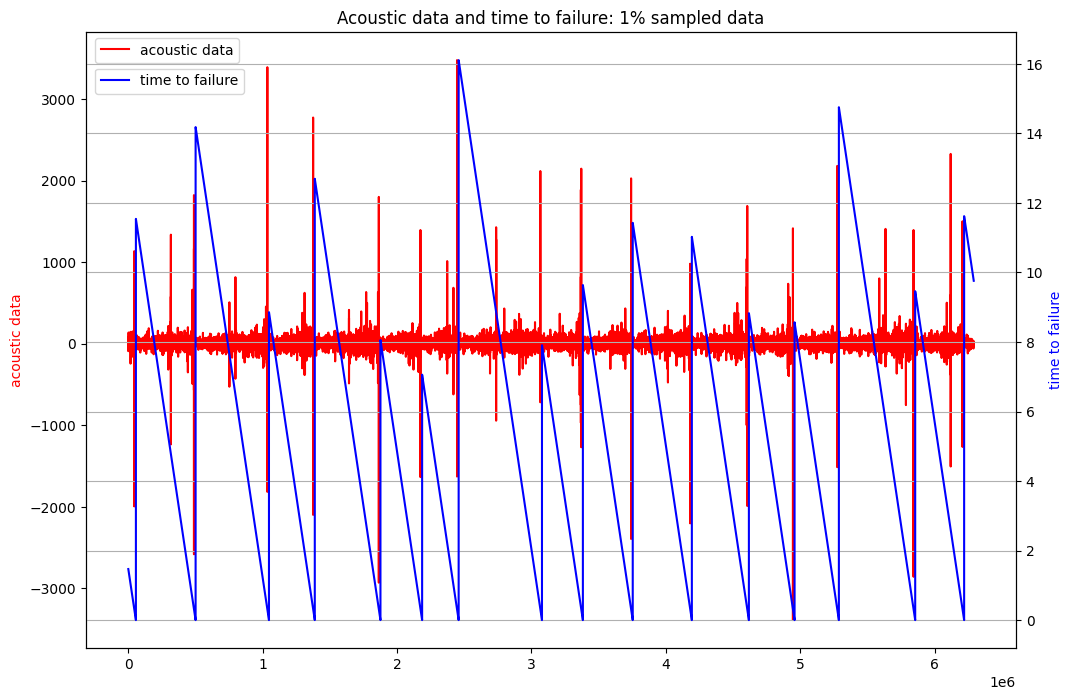

In [7]:
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

The plot shows only 1% of the full data.
The acoustic data shows complex oscilations with variable amplitude. Just before each failure there is an increase in the amplitude of the acoustic data. We see that large amplitudes are also obtained at different moments in time (for example about the mid-time between two succesive failures).  

Let's plot as well the first 1% of the data.

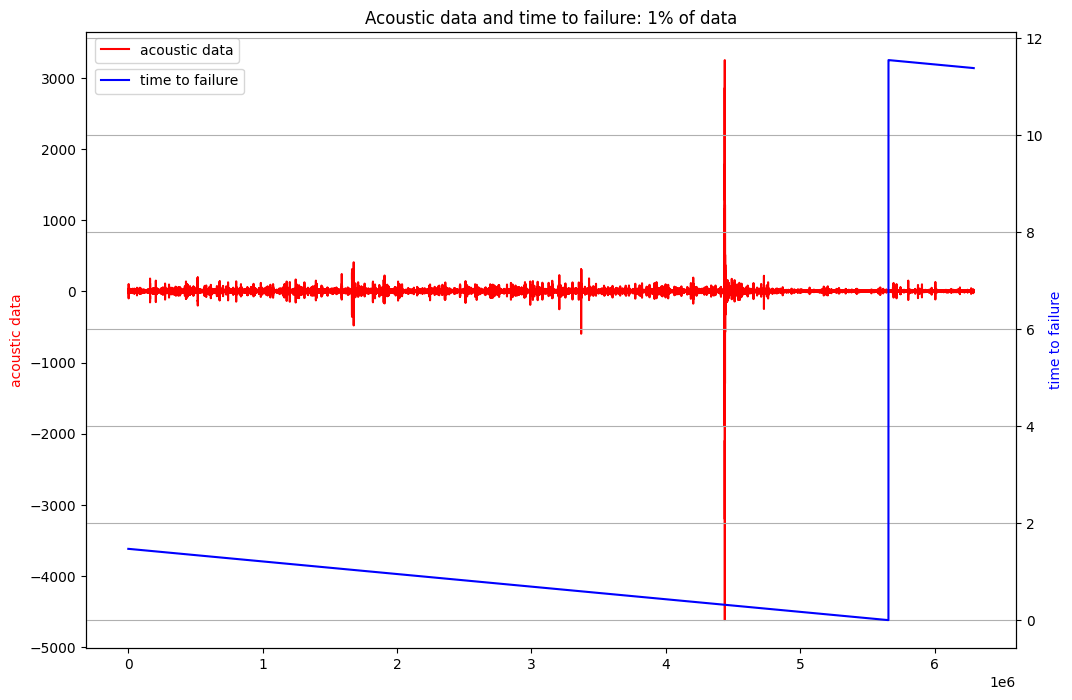

In [8]:
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

On this zoomed-in-time plot we can see that actually the large oscilation before the failure is not quite in the last moment. There are also trains of intense oscilations preceeding the large one and also some oscilations with smaller peaks after the large one. Then, after some minor oscilations, the failure occurs.

# <a id='4'>Features engineering</a>  

The test segments are 150,000 each.   
We split the train data in segments of the same dimmension with the test sets.

We will create additional aggregation features, calculated on the segments.


In [9]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


Let's define some computation helper functions.

In [24]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    x = np.array(x, dtype=float)
    sta = np.cumsum(x ** 2)
    sta = np.require(sta, dtype=float)
    # Convert to float
    sta = np.require(sta, dtype=float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

## Process train file

Now let's calculate the aggregated functions for train set.

In [25]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
total_mean = train_df['acoustic_data'].mean()
total_std = train_df['acoustic_data'].std()
total_max = train_df['acoustic_data'].max()
total_min = train_df['acoustic_data'].min()
total_sum = train_df['acoustic_data'].sum()
total_abs_sum = np.abs(train_df['acoustic_data']).sum()

In [26]:
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)

    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()

    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()

    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()

    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()

    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()

    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()

    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()

    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()

    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])

    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)

    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)

    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()

    X.loc[seg_id, 'mad'] = np.mean(np.abs(xc - np.mean(xc)))
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()

    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()

    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values

        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()

        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [27]:
# iterate over all segments
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

  0%|          | 0/4194 [00:00<?, ?it/s]

Let's check the result. We plot the shape and the head of train_X.

In [28]:
train_X.shape

(4194, 154)

In [29]:
train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113333333334,5.101106130606765,104.0,-98.0,1.200000000000000e+01,2349.811481800189085,732617.0,-20121.154171234855312,-4.365574568510056e-16,1399.854635310395224,...,0.295714650592636,5.629,3.896,4.072,4.379,5.338,5.484,-0.000001704697987,74222.343442640820285,5.629
1,4.725766666666667,6.588823781946801,181.0,-154.0,5.000000000000001e+00,2566.032248433366476,708865.0,-31056.675076437575626,1.455191522836685e-15,1810.312265881220810,...,0.231586699576737,5.667,3.412,4.233,4.345,5.066,5.223,-0.000002449664430,74364.426477527638781,5.667
2,4.906393333333333,6.967397033524431,140.0,-106.0,4.999999999999997e+00,2683.549049300198476,735959.0,-27654.557067499525147,-1.940255363782247e-16,1921.220575571685913,...,0.267011771793293,5.957,4.055,4.239,4.446,5.344,5.486,0.000001140939597,74594.984584474615986,5.957
3,4.902240000000000,6.922305187180113,197.0,-199.0,5.000000000000001e+00,2685.788524809800037,735336.0,-25622.393603785181767,5.335702250401179e-16,1891.826366239777371,...,0.266699817775971,5.858,3.722,4.304,4.433,5.317,5.453,-0.000002550335570,74333.143622613599291,5.858
4,4.908720000000000,7.301110189758817,145.0,-126.0,1.200000000000000e+01,2761.715771037997456,736308.0,-26271.075116963394976,-2.910383045673371e-15,1995.742969422665965,...,0.228004751350508,6.078,3.918,4.434,4.543,5.306,5.491,0.000001550335570,74428.435968884237809,6.078
5,4.913513333333333,5.434111112860393,142.0,-144.0,1.400000000000000e+01,2420.968091487370657,737027.0,-24168.435450134638813,-5.820766091346741e-16,1479.700814354036993,...,0.293941260517808,5.838,4.042,4.270,4.422,5.402,5.620,-0.000003697986577,74539.909434154062183,5.838
6,4.855660000000000,5.687823395051908,120.0,-78.0,-8.246085296074549e-16,2437.523640910996164,728349.0,-23876.893136299160687,-3.880510727564494e-16,1564.532358246386593,...,0.219471906215868,5.546,3.958,4.285,4.504,5.214,5.370,-0.000000114093960,74501.904750525020063,5.546
7,4.505426666666667,5.854511569720713,139.0,-134.0,3.000000000000002e+00,2361.259303846149123,675814.0,-25427.499452212759934,-3.031649005909761e-16,1615.715785650434327,...,0.218514054888406,5.180,3.489,4.040,4.148,4.863,4.953,-0.000001395973154,74515.926219409957412,5.180
8,4.717833333333333,7.789643113079984,168.0,-156.0,1.000000000000001e+00,2805.303459520912384,707675.0,-34542.227581035360345,-5.093170329928398e-16,2137.915924446047939,...,0.240916531351268,5.717,3.933,4.158,4.315,5.104,5.337,0.000002221476510,74464.251034999178955,5.717
9,4.730960000000000,6.890459152667711,152.0,-126.0,4.999999999999999e+00,2620.173753780462903,709644.0,-23173.271871617391298,-2.910383045673371e-16,1900.967779842677828,...,0.258462298074467,5.423,3.832,4.190,4.301,5.128,5.261,0.000005127516779,74344.216474791013752,5.423


We scale the data.

In [30]:
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

Let's check the obtained dataframe.

In [31]:
scaled_train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.424140499795022,-0.170213582943171,-0.218193508692627,0.193218185209325,1.199316205489369,-0.105006593381723,1.424140499795018,0.156736086729651,-0.237183229140293,-0.169052005333305,...,0.268470130890001,-0.004741890462161,0.178277723969481,0.287332145975991,0.965402446610929,1.509153430549683,0.885262121712506,-0.631300343511894,-1.832422175860377,-0.004741890462161
1,0.805716032556442,0.004734017014316,0.063936007992510,-0.018037271219829,0.078885810556771,-0.008598597346281,0.805716032556438,-0.222117948425052,0.704281462124092,0.007211752080005,...,-0.141264321988320,0.007341389309125,-0.025386948237320,0.622391465890732,0.842747052156309,0.522427542165818,0.294356817530996,-0.912053970881953,-0.890022480697742,0.007341389309125
2,1.511155259373638,0.049252196732055,-0.086288799593083,0.163038834290874,0.078885810556770,0.043799511533280,1.511155259373636,-0.104253774698728,-0.116482627696141,0.054839360725539,...,0.085078050610279,0.099555892826834,0.245184093558079,0.634878148620475,1.207105723918564,1.530919442793446,0.889790131706233,0.441127926802558,0.639209280695772,0.099555892826834
3,1.494934375107487,0.043949637951170,0.122560323147863,-0.187796120136112,0.078885810556771,0.044798043493984,1.494934375107485,-0.033850788412464,0.245619176636315,0.042216538302113,...,0.083084874365199,0.068075769212167,0.105059432721582,0.770150544859347,1.160208073097680,1.432972387696517,0.815077966809722,-0.949993650256284,-1.097513494373596,0.068075769212167
4,1.520242078970568,0.088495070341074,-0.067968701107035,0.087590456994748,1.199316205489369,0.078652301654897,1.520242078970566,-0.056323939067857,-1.468329363870642,0.086841682459309,...,-0.164150560726067,0.138031599466982,0.187535209069790,1.040695337337088,1.557034349274394,1.393068031916287,0.901110156690553,0.595415956258175,-0.465464227208672,0.138031599466982
5,1.538962489544185,-0.131053986788160,-0.078960760198664,0.019686917428235,1.519439175470111,-0.073279455182017,1.538962489544182,0.016520649604222,-0.309603590006784,-0.134763478369498,...,0.257139361692816,0.061716148279912,0.239713761453351,0.699392676057474,1.120525445480008,1.741324227816475,1.193166801286013,-1.382505995123670,0.273910179965897,0.061716148279912
6,1.313015726042317,-0.101218785996422,-0.159569193537274,0.268666562505451,-0.721421614395085,-0.065897706573636,1.313015726042313,0.026620944137275,-0.213043108851462,-0.098334074796606,...,-0.218669699063587,-0.031134317331023,0.204367000161261,0.730609382881830,1.416341396811739,1.059322510845276,0.627165552070007,-0.031853409397449,0.021835030421887,-0.031134317331023
7,-0.054824008985421,-0.081617152532347,-0.089952819290292,0.057411106076298,-0.241237159423971,-0.099902265987057,-0.054824008985424,-0.027098806829572,-0.170797898346009,-0.076354258709420,...,-0.224789724471834,-0.147515380391304,0.007014249613762,0.220736504750701,0.132067266639831,-0.213989205414785,-0.316924531622290,-0.514951993430610,0.114835774764259,-0.147515380391304
8,0.774732321036825,0.145943916470089,0.016303751928785,-0.025582108949441,-0.561360129404714,0.098087075492250,0.774732321036822,-0.342872656184990,-0.273393409573538,0.147895339130580,...,-0.081652975344229,0.023240441639764,0.193847130729092,0.466307931768960,0.734521704108117,0.660278953042976,0.552453387173494,0.848347152087057,-0.227912239275442,0.023240441639764
9,0.825998647072221,0.040204715451199,-0.042320563226568,0.087590456994748,0.078885810556771,0.015541887002806,0.825998647072220,0.050997446880598,-0.164762868273802,0.046142156416401,...,0.030452666809819,-0.070245986064396,0.151346858223127,0.532903572994250,0.684016541685625,0.747343002018023,0.380389007411829,1.943539230026109,-1.024070155238219,-0.070245986064396


## Process test data

We apply the same processing done for the training data to the test data.

We read the submission file and prepare the test file.

In [33]:
submission = pd.read_csv('input/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

Let's check the shape of the submission and test_X datasets.

In [34]:
submission.shape, test_X.shape

((2624, 1), (2624, 154))

In [36]:
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv('input/test/' + seg_id + '.csv')
    create_features(seg_id, seg, test_X)

  0%|          | 0/2624 [00:00<?, ?it/s]

We scale also the test data.

In [37]:
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

In [38]:
scaled_test_X.shape

(2624, 154)

In [39]:
scaled_test_X.tail(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
2614,-1.081634623438432,-0.268601942296902,-0.350098217792172,0.329025264342352,-0.081175674433600,-0.256057804503499,-1.081634623438434,0.296094951842351,-0.357883830584445,-0.265116961140863,...,-0.131863367972886,-0.197756385756125,0.067608697543058,-0.245432983826332,-0.755380587355362,-0.834320554361995,-0.568229086274198,-0.621183095678739,-0.332742633283314,-0.197756385756125
2615,-0.734695164615844,-0.320940103312901,-0.390402434461477,0.400701222773672,0.559070265527884,-0.271490841421192,-0.734695164615847,0.457524666141680,0.100778454903333,-0.320648190853422,...,-0.090273729721340,-0.210475627620636,-0.012763104918716,-0.420246542042718,-0.632725192900742,-0.772650186338005,-0.620301201202069,0.066789756975814,0.379958267345616,-0.210475627620636
2616,-2.073321685925087,0.185999424044961,0.045615909506462,0.027231755157847,0.238947295547142,0.058192651768876,-2.073321685925090,-0.198272835507732,0.173198815769824,0.182882262889467,...,-0.335397473385972,-0.255310955193040,-0.100709213371653,-0.919713851232396,-1.650043464553771,-2.114887608036642,-1.421758970091934,-0.681886582677671,-0.455029743769391,-0.255310955193040
2617,-0.427930383839279,-0.291596382506079,-0.196209390509370,0.310163170018320,0.238947295547142,-0.242327244436703,-0.427930383839283,0.412107554533329,-0.237183229140293,-0.293675558394082,...,-0.306297807314964,-0.147833361437917,0.084019693857243,-0.076862766974816,-0.026663243830852,-0.547734726485800,-0.409748736493715,0.491714165968333,0.259853681784336,-0.147833361437917
2618,-3.374741716678421,-0.152003490043633,-0.298801942031238,0.234714792722194,-0.721421614395085,-0.249113638779983,-3.374741716678424,0.271951919845560,0.462880259235788,-0.156716904848106,...,-0.176297932752017,-0.424476871991044,-0.208011881579782,-1.854133942174751,-3.157983314025280,-3.239464907297666,-2.157560594072741,-0.466895066223123,-0.517982573703920,-0.424476871991044
2619,-1.654729139621841,-0.172408272635962,-0.339106158700543,0.374294290720027,-1.041544584375827,-0.215590231150948,-1.654729139621846,0.224509483145720,0.293899417213976,-0.166937482945480,...,-0.035382823436088,-0.240683827048852,-0.014025489250577,-0.663736855272686,-1.487705442481479,-1.469162578138378,-0.817269635929239,0.643472883465663,-0.554972820552376,-0.240683827048852
2620,-1.487885758598570,-0.060792925011241,0.001647673139947,-0.221747889919369,0.238947295547142,-0.124402235161050,-1.487885758598571,0.230258375488919,-0.599285033472749,-0.063658336471214,...,0.301725399442915,-0.128754498641149,-0.147417433650486,-1.354666632985074,-2.028832182722451,-1.425630553650856,-0.894245805822615,1.559083812366209,-0.820948539836463,-0.128754498641149
2621,-3.010670087956753,0.343254632011228,0.536594548932544,-0.580127682075968,-0.241237159423972,0.174257853534564,-3.010670087956756,-0.487617919728306,0.173198815769824,0.340983182941972,...,-0.166314501054057,-0.130344403874213,-0.335933493874962,-1.564859125602396,-2.624071596987521,-2.956506748128763,-1.935688104380066,1.604611427615407,-0.954385032173800,-0.130344403874213
2622,-0.694312192710866,0.782096807867043,0.727123573187442,-0.640486383912869,-0.241237159423971,0.628381731544477,-0.694312192710869,-1.113687307556833,-0.937246717516374,0.778366527088963,...,-0.045220121607113,0.055356527347656,-0.178977041946994,-0.303704169898461,-0.679622843721626,-0.761767180216124,0.006828182929265,0.916638574960853,1.362109444329824,0.055356527347656
2623,-1.248764408517769,-0.349888468230894,-0.331778119306124,0.347887358666383,0.238947295547142,-0.306138783032271,-1.248764408517773,0.388179518203963,0.167163785697616,-0.350400284361961,...,-0.256027867555159,-0.247997391120946,0.047831343010580,-0.497247752209461,-0.971831


# <a id='5'>Model</a>  

Let's prepare the model.

## Run model

We define the folds for cross-validation.

In [40]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

We define the model parameters.

In [41]:
params = {'num_leaves': 51,
         'min_data_in_leaf': 10,
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

We run the model. During training for each fold, we validate using the validation set and also we predict using the current model for test set. The final result will be the average over the all folds for the predictions done at each fold training.

In [48]:
from lightgbm import early_stopping

oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
# run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X, train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)

    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators=20000, n_jobs=-1)  # <--- Corrected indentation
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        eval_metric='mae',
        callbacks=[early_stopping(stopping_rounds=500)]
    )

    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    # predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits


fold 0
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[3977]	training's l1: 1.1623	valid_1's l1: 2.09612
fold 1
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[4841]	training's l1: 1.03655	valid_1's l1: 2.10278
fold 2
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[4425]	training's l1: 1.10011	valid_1's l1: 2.06668
fold 3
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[2549]	training's l1: 1.43457	valid_1's l1: 2.03542
fold 4
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[4007]	training's l1: 1.1515	valid_1's l1: 2.08504


## Features importance

Let's print features importance.

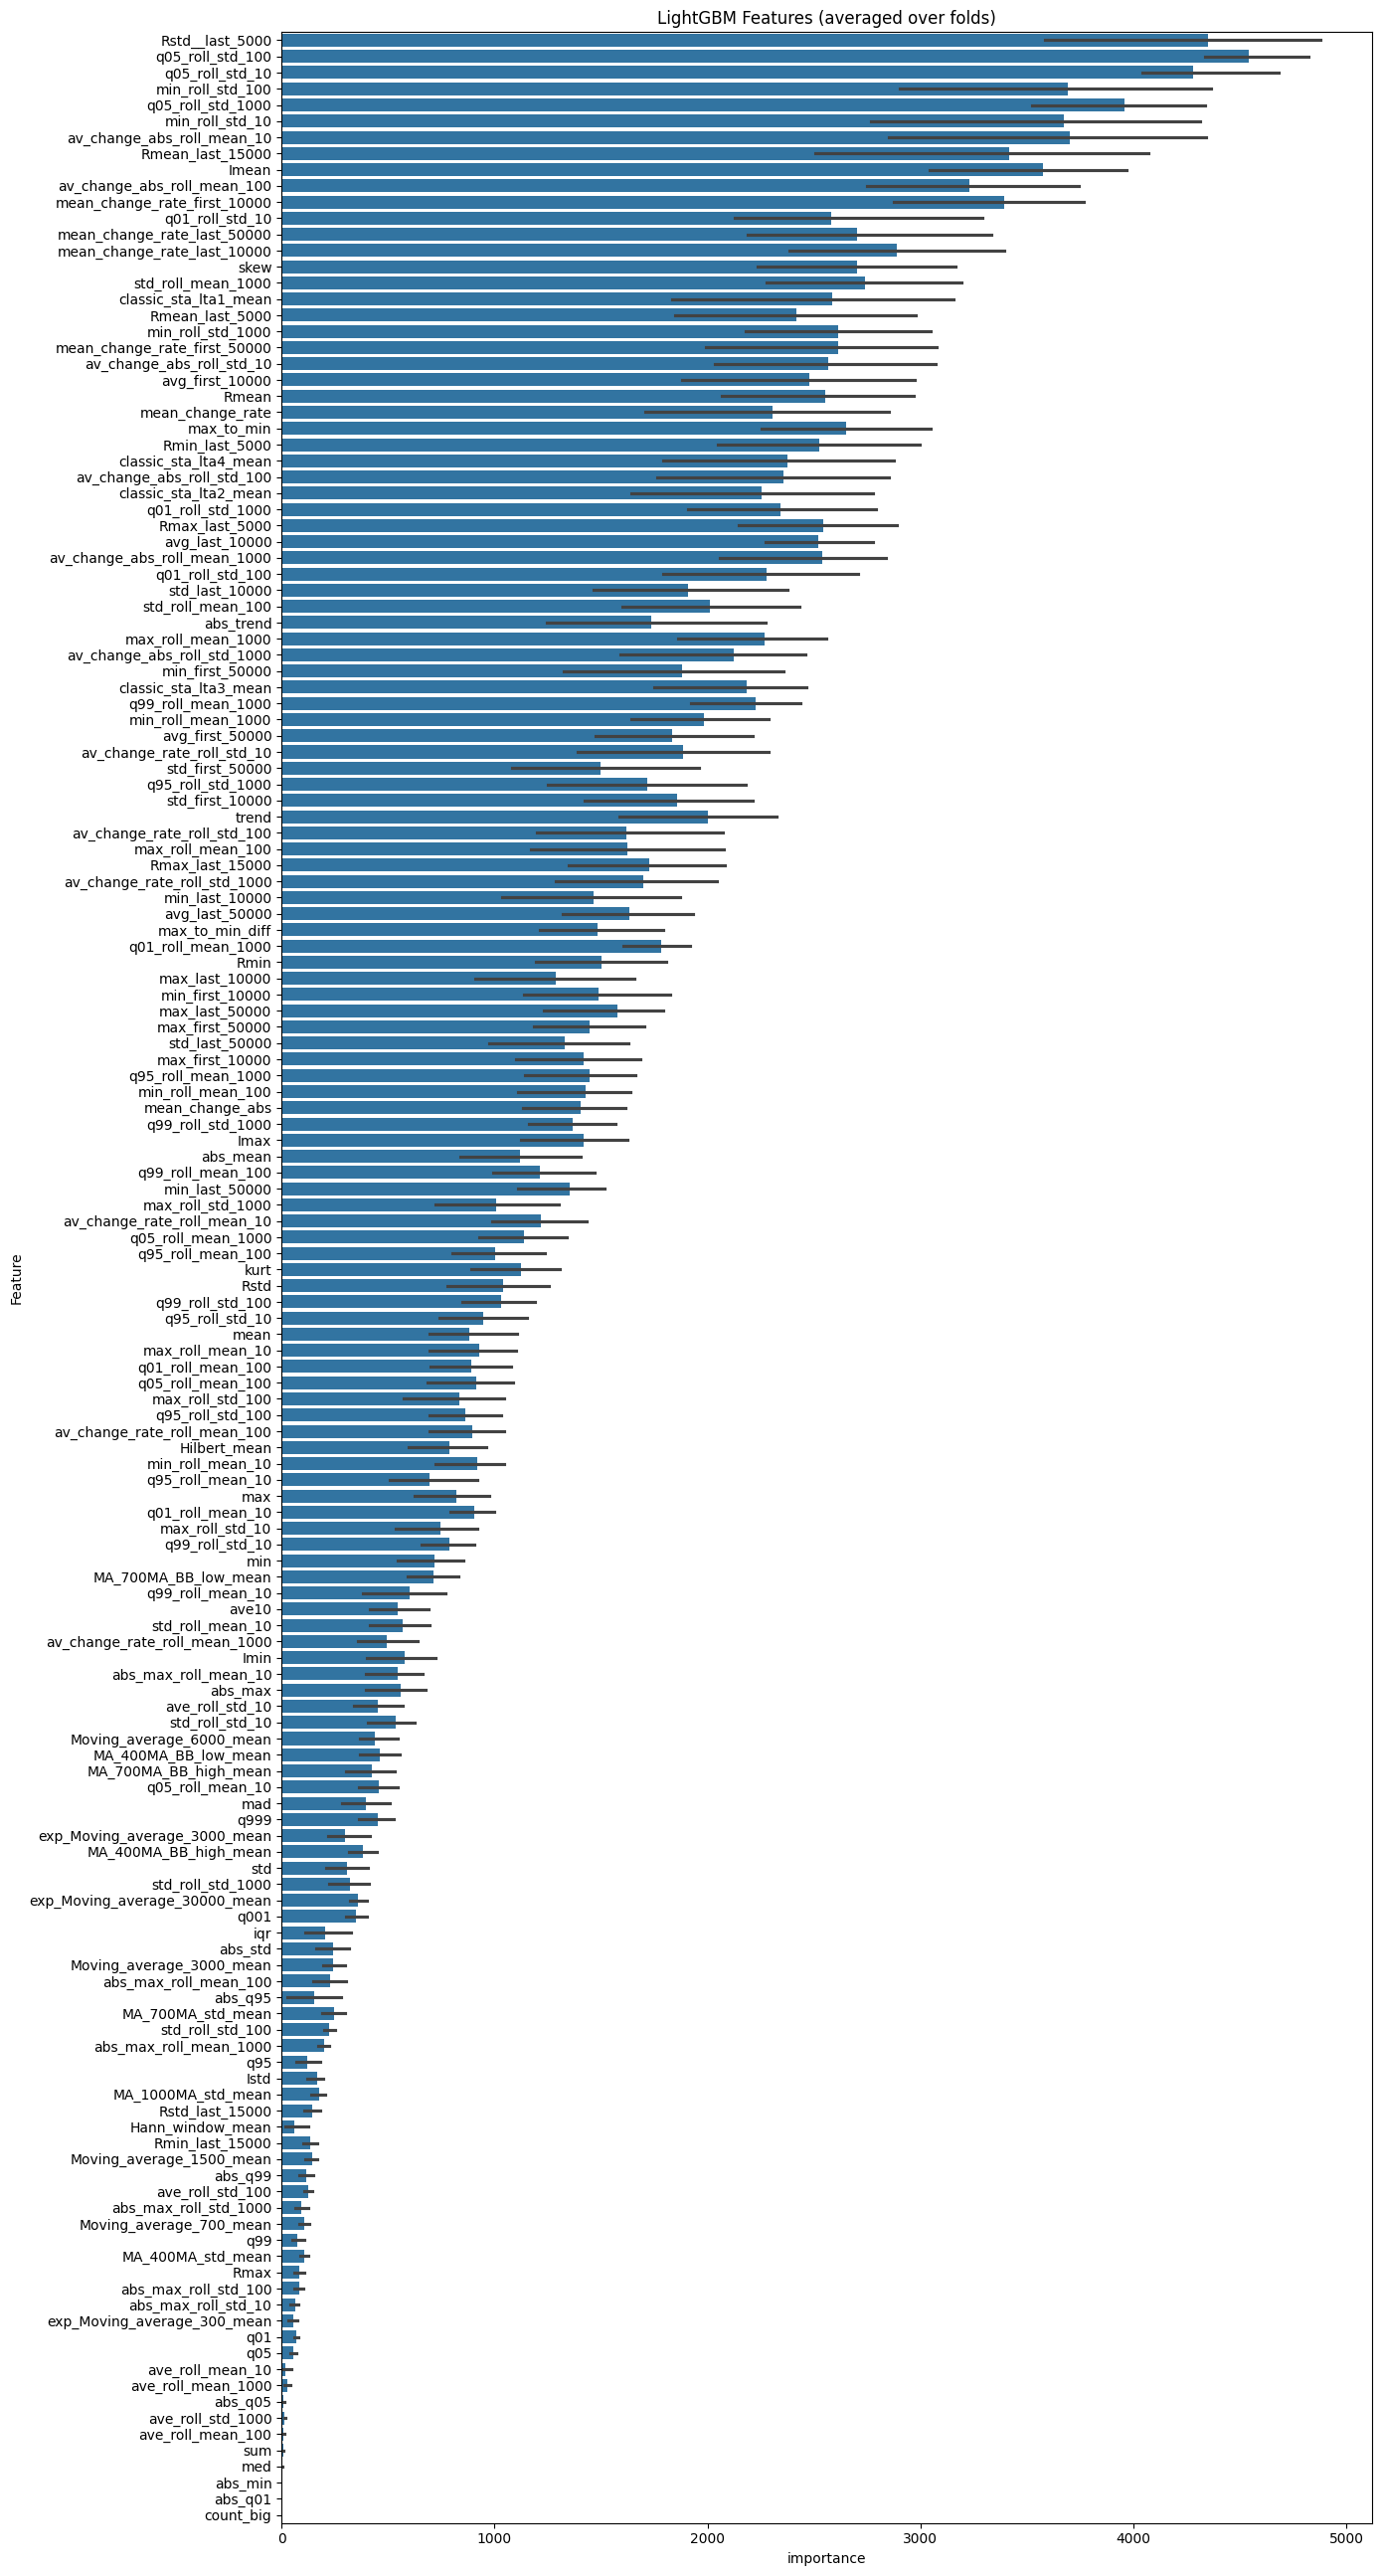

In [49]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

# <a id='6'>Submission</a>  

We set the predicted time to failure in the submission file.

In [50]:
submission.time_to_failure = predictions
submission.to_csv('submission.csv',index=True)

In [51]:
import pickle

# Save
with open(f'lgbm_fold_{fold_}.pkl', 'wb') as f:
    pickle.dump(model, f)

In [53]:
# Load
with open('lgbm_fold_4.pkl', 'rb') as f:
    model = pickle.load(f)